# iMet Collection 2021 with Lightning ⚡

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
%reload_ext autoreload
%autoreload

In [2]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# copy the dataset to local drive
#! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip imet.zip

In [ ]:
! rm -rf imet-2021-fgvc8/train-1/
! rm -rf imet-2021-fgvc8/test/

# extract dataset to the drive
! unzip /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip -d imet-2021-fgvc8 | awk 'BEGIN {ORS=" "} {if(NR%500==0)print "."}'
! ls -l

In [2]:
! pip install -q -U pytorch-lightning torchmetrics timm
! pip uninstall -y kaggle-imet
! pip install -q https://github.com/Borda/kaggle_iMet-collection/archive/main.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

Found existing installation: kaggle-imet 0.1.1
Uninstalling kaggle-imet-0.1.1:
  Successfully uninstalled kaggle-imet-0.1.1
pytorch-lightning                 1.3.5
torch                             1.8.1
torchmetrics                      0.3.2
torchvision                       0.9.1
kaggle-imet                       0.1.2


In [3]:
! nvidia-smi

Sat Jun 12 07:18:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Exploration

Checking what data do we have available...

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_DATASET = "/content/imet-2021-fgvc8/"
PATH_DATASET = "/home/jovyan/work/kaggle-iMet/"
pd.read_csv(PATH_DATASET + "train-from-kaggle.csv").head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


Checkout the label mapping , there seems to be some topics note that country as operand inside AND and OR which would be better encoded with just primitives

In [5]:
df_label_map = pd.read_csv(PATH_DATASET + "label_map.csv", index_col="attribute_id")
print(f"len: {len(df_label_map)}")
print(df_label_map.head())

df_label_map["is_OR"] = ['or' in name for name in df_label_map["attribute_name"]]
df_label_map["is_AND"] = ['and' in name for name in df_label_map["attribute_name"]]
df_label_map["topic"] = [name.split("::")[0] if "::" in name else "." for name in df_label_map["attribute_name"]]
topics = set(df_label_map['topic'])

print(f"include OR: {sum(df_label_map['is_OR'])}")
print(f"include AND: {sum(df_label_map['is_AND'])}")
print(f"topics: {topics}")

len: 3474
                    attribute_name
attribute_id                      
0             country::afghanistan
1                country::alamania
2                 country::algeria
3                  country::arabia
4                 country::armenia
include OR: 480
include AND: 409
topics: {'country', 'dimension', 'medium', 'tags', 'culture'}


Also labeling per image seems to be one to many with multiple same topis per image...

len: 142119
                                 id                      attribute_ids
0  000040d66f14ced4cdd18cd95d91800f                       448 2429 782
1  0000ef13e37ef70412166725ec034a8a  2997 3231 2730 3294 3099 2017 784
2  0001eeb4a06e8daa7c6951bcd124c3c7                       2436 1715 23
3  000226398d224de78b191e6db45fd94e                  2997 3433 448 782
4  00029c3b0171158d63b1bbf803a7d750            3465 3322 3170 1553 781
max lbs: 26
{0: 0, 1: 1795, 2: 11941, 3: 33042, 4: 34967, 5: 28014, 6: 16172, 7: 8908, 8: 4094, 9: 1863, 10: 736, 11: 315, 12: 127, 13: 64, 14: 28, 15: 20, 16: 13, 17: 8, 18: 4, 19: 3, 20: 1, 21: 3, 22: 0, 23: 0, 24: 0}


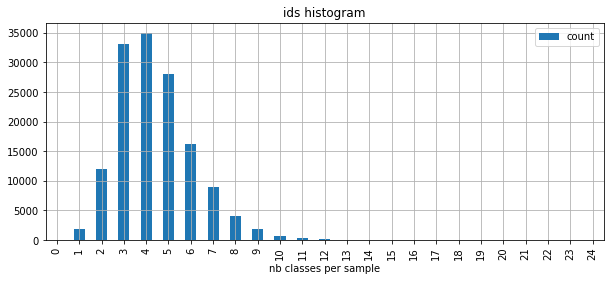

In [ ]:
df_train = pd.read_csv(PATH_DATASET + "train-from-kaggle.csv")
print(f"len: {len(df_train)}")
print(df_train.head())

df_train['nb_classes'] = [len(lbs.split(" ")) for lbs in df_train['attribute_ids']]
lb_hist = dict(zip(range(25), np.bincount(df_train['nb_classes'])))
df_hist = pd.DataFrame([dict(lb=lb, count=count) for lb, count in lb_hist.items()]).set_index("lb")

print(f"max lbs: {max(df_train['nb_classes'])}")
ax = df_hist.plot(kind="bar", grid=True, title="labels combination histogram", figsize=(10, 4))
ax.set_xlabel('nb classes per sample')
print(lb_hist)

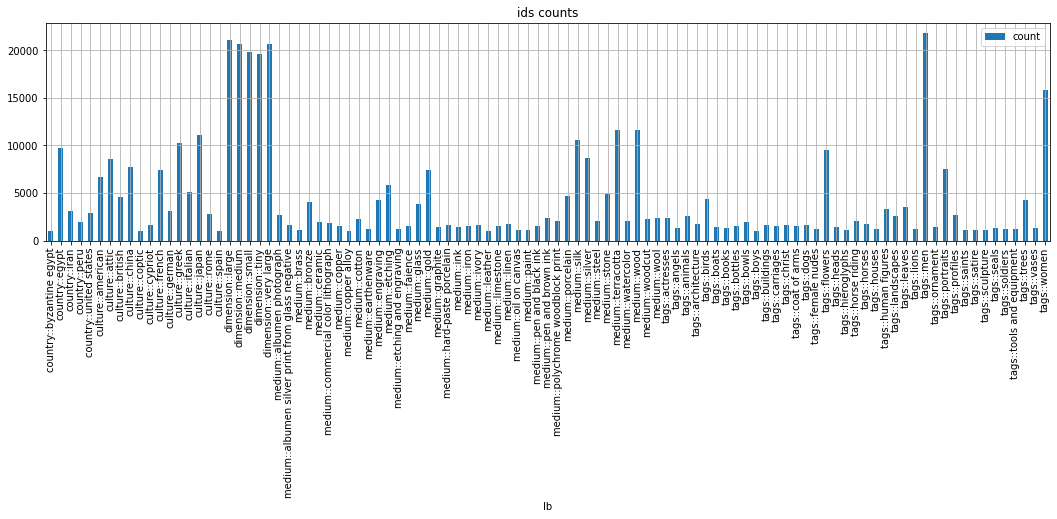

In [ ]:
import itertools

label_map = dict(zip(df_label_map.index, df_label_map['attribute_name']))
COUNT_THR = 1000

labels_all = list(itertools.chain(*[[int(lb) for lb in lbs.split(" ")] for lbs in df_train['attribute_ids']]))
lb_hist = dict(zip(range(max(labels_all) + 1), np.bincount(labels_all)))
df_hist = pd.DataFrame([dict(lb=label_map[lb], count=count) for lb, count in lb_hist.items() if count > COUNT_THR]).set_index("lb")

ax = df_hist.plot(kind="bar", grid=True, title="ids counts", figsize=(18, 4))
# print(lb_hist)

Text(0.5, 0, 'nb of sampls per label')

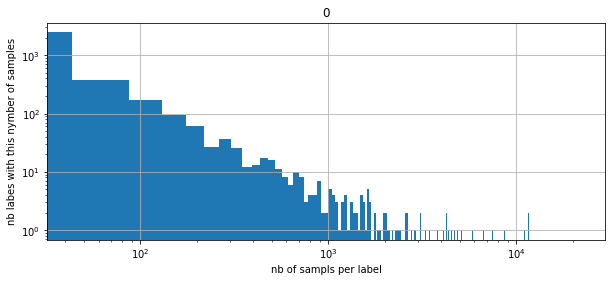

In [ ]:
labels_counts = np.bincount(labels_all)
[[ax]] = pd.DataFrame(labels_counts).hist(bins=500, figsize=(10, 4))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('nb labes with this nymber of samples')
ax.set_xlabel('nb of sampls per label')

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations. We define the sample pair as:
- RGB image
- one-hot lable encding

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

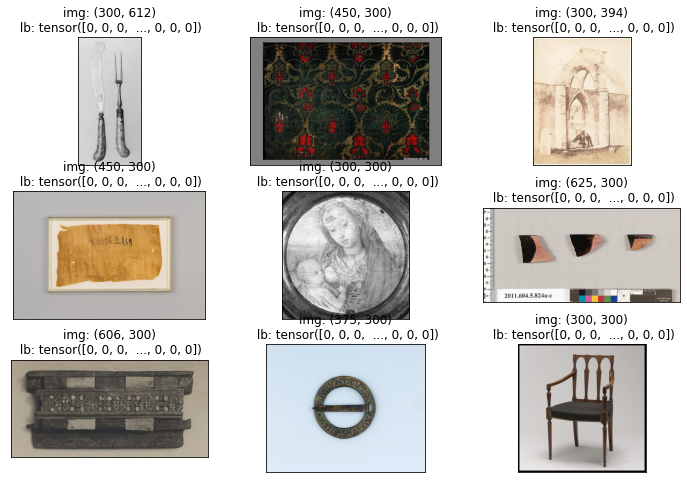

In [ ]:
from PIL import ImageFile
import matplotlib.pyplot as plt

from kaggle_imet.data import IMetDataset

ImageFile.LOAD_TRUNCATED_IMAGES = True

dataset = IMetDataset(
    df_data=PATH_DATASET + "train-from-kaggle.csv",
    path_img_dir=PATH_DATASET + "train-1/train-1",
)

# quick view
fig = plt.figure(figsize=(12, 8))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"img: {img.size}\n lb: {lb}")

100%|██████████| 4/4 [00:16<00:00,  3.44s/it]

nb labels: 583


batch labels: [1, 1, 1, 3, 2, 3, 4, 10, 2, 6, 10, 1, 1, 1, 6, 1, 16, 1, 1, 15, 1, 1, 1, 1, 5, 2, 1, 3, 3, 2, 1, 1, 3, 3, 2, 1, 2, 5, 1, 1, 1, 1, 2, 1, 4, 2, 2, 4, 1, 1, 5, 7, 1, 2, 1, 1, 3, 8, 1, 2, 1, 1, 1, 17, 15, 1, 15, 1, 13, 1, 2, 2, 1, 3, 8, 1, 1, 1, 18, 1, 1, 1, 1, 7, 19, 1, 2, 4, 3, 1, 4, 1, 7, 1, 2, 4, 2, 6, 5, 2, 1, 2, 2, 1, 3, 1, 1, 1, 3, 3, 5, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 11, 2, 2, 1, 1, 1, 1, 3, 3, 6, 4, 2, 1, 3, 1, 2, 4, 5, 4, 2, 1, 24, 1, 2, 1, 1, 2, 2, 1, 15, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 13, 1, 1, 10, 5, 1, 2, 1, 2, 27, 5, 17, 1, 4, 1, 1, 2, 2, 10, 16, 2, 1, 3, 1, 1, 1, 1, 3, 2, 3, 1, 1, 3, 2, 1, 1, 2, 2, 30, 38, 38, 24, 37, 5, 1, 1, 2, 1, 1, 1, 1, 4, 7, 1, 5, 1, 3]
image size: torch.Size([3, 224, 224])


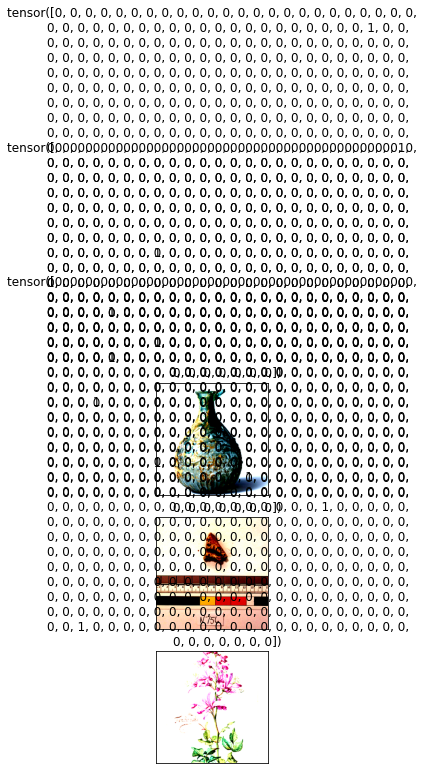

In [11]:
import torch

from kaggle_imet.data import IMetDM, TORCHVISION_TRAIN_TRANSFORM, TORCHVISION_VALID_TRANSFORM

dm = IMetDM(
    base_path=PATH_DATASET,
    path_csv="train-from-kaggle_min-lb-sample-100.csv",
    batch_size=228,
    train_transforms=TORCHVISION_TRAIN_TRANSFORM,
    valid_transforms=TORCHVISION_VALID_TRANSFORM,
    # num_workers=0,
)
dm.setup()
print(f"nb labels: {dm.num_classes}")

# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.val_dataloader():
    batch_lb_sum = torch.sum(lbs, axis=0).numpy()
    print(f'batch labels: {list(batch_lb_sum[batch_lb_sum > 0])}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

batch labels: [5, 5, 1, 6, 1, 1, 1, 4, 11, 7, 10, 1, 3, 1, 9, 2, 11, 1, 2, 3, 3, 21, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1, 3, 1, 4, 1, 1, 1, 2, 6, 1, 7, 1, 2, 1, 1, 14, 13, 17, 11, 3, 1, 5, 9, 2, 2, 1, 25, 5, 1, 2, 5, 2, 26, 1, 1, 2, 1, 2, 4, 1, 3, 1, 2, 1, 1, 7, 3, 1, 2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2, 2, 1, 1, 1, 2, 4, 1, 15, 1, 1, 2, 3, 1, 1, 1, 6, 2, 6, 1, 1, 1, 1, 3, 1, 3, 7, 3, 3, 1, 46, 2, 1, 1, 1, 3, 2, 1, 13, 8, 1, 1, 1, 1, 1, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 9, 1, 2, 8, 1, 3, 1, 3, 1, 23, 1, 1, 8, 23, 1, 1, 1, 1, 10, 16, 7, 1, 1, 1, 2, 1, 2, 2, 1, 5, 1, 1, 2, 5, 2, 1, 33, 38, 36, 31, 31, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 2, 6, 2]
image size: torch.Size([3, 224, 224])


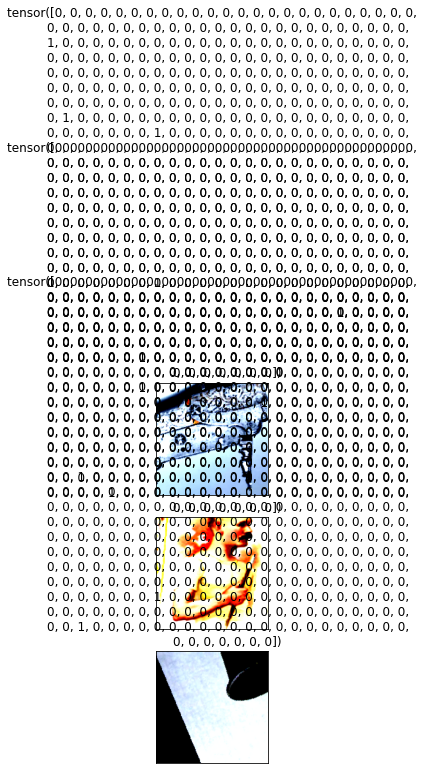

In [12]:
# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    batch_lb_sum = torch.sum(lbs, axis=0).numpy()
    print(f'batch labels: {list(batch_lb_sum[batch_lb_sum > 0])}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision. Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [13]:
# import gc, torch
# del net
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [14]:
import timm
from kaggle_imet.models import LitResnet, LitMet

# see: https://pytorch.org/vision/stable/models.html
# net = LitResnet(arch='resnet50', num_classes=dm.num_classes)
net = timm.create_model('tv_resnet50', pretrained=True, num_classes=dm.num_classes)
# net = timm.create_model('vit_base_resnet50d_224', pretrained=True, num_classes=dm.num_classes)
# print(net)

model = LitMet(model=net, num_classes=dm.num_classes, name='imet', lr=1e-3)

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [ ]:
import gc
import pytorch_lightning as pl
print(pl.__version__)

logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.name)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid_f1',
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename='checkpoint/{epoch:02d}-{valid_acc:.4f}-{valid_f1:.4f}',
    # verbose=False,
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # accelerator='ddp_spawn',
    callbacks=[ckpt, swa],
    logger=logger,
    max_epochs=35,
    precision=16,
    #overfit_batches=5,
    auto_lr_find=True,
    accumulate_grad_batches=24,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)
gc.collect()
torch.cuda.empty_cache()

# ==============================

# lr_find_kwargs = dict(min_lr=1e-5, max_lr=1e-2, num_training=25)
# trainer.tune(model, datamodule=dm, lr_find_kwargs=lr_find_kwargs)
# print(f"LR: {model.learning_rate}")

# ==============================

# dm.train_dataset.transforms = TORCHVISION_TRAIN_TRANSFORM
# dm.valid_dataset.transforms = TORCHVISION_VALID_TRANSFORM

dm.batch_size = 256
trainer.fit(model=model, datamodule=dm)

Quick visualization of the training process...

   valid_loss  valid_acc  valid_prec  valid_f1  epoch  step  train_loss  \
0    0.046347   0.993110    0.000000  0.000000      0     4         NaN   
1    0.038086   0.993110    0.000000  0.000000      0     9         NaN   
2    0.035040   0.993110    0.000000  0.000000      0    13         NaN   
3    0.033364   0.993255    0.036848  0.026720      0    18         NaN   
4    0.032303   0.993360    0.050699  0.042793      1    23         NaN   

   train_acc  train_prec  train_f1  
0        NaN         NaN       NaN  
1        NaN         NaN       NaN  
2        NaN         NaN       NaN  
3        NaN         NaN       NaN  
4        NaN         NaN       NaN  


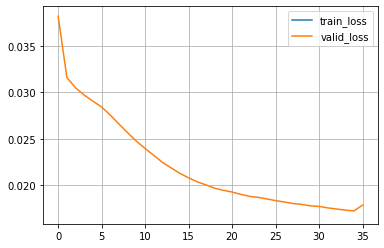

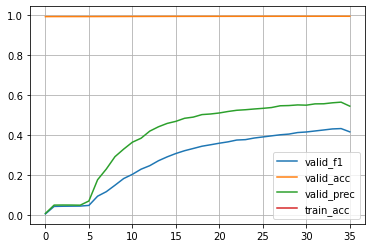

In [16]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True)
df_metrics[['valid_f1', 'valid_acc', 'valid_prec', 'train_acc']].plot(grid=True, legend=True)

## Predictions

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

for imgs, names in dm.val_dataloader():
    with torch.no_grad():
        onehots = model.cuda()(imgs.cuda()).cpu()
    print(np.round(onehots.detach().numpy(), decimals=2))
    break

for imgs, lbs in dm.val_dataloader():
    print(np.round(lbs.to(onehots.dtype).numpy(), decimals=2))
    break

In [18]:
import os
import tqdm

preds = []
dm.batch_size = 128
model.cuda().eval()

pbar = tqdm.tqdm(total=len(dm.test_dataset))
for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model(imgs.cuda()).cpu()
    # print(np.round(onehots.detach().numpy(), decimals=2))
    for oh, name in zip(onehots, names):
        lbs = dm.onehot_to_labels(oh)
        preds.append({'id': os.path.splitext(name)[0], 'attribute_ids': " ".join(lbs)})
    # break
    pbar.update(len(names))

df_preds = pd.DataFrame(preds)
print(df_preds.head())
print(len(df_preds))
df_preds.to_csv('submission.csv', index=False)

100%|██████████| 53110/53110 [06:10<00:00, 147.16it/s]

                                 id  attribute_ids
0  dcc0e36f8aed00d6f75ee0727cfb3d10           2362
1  252ceeac3d3fac3d8cee11fd44bb73e6       1856 785
2  66fdbdfd57fb101c7313ff6ce6cc2fa5  1301 3170 781
3  dfbc3d71317bdfb358eca872ffe0bb2b            785
4  540725af077b3132e0fa55bf0129f878            783
53110


In [19]:
# df_preds = pd.DataFrame(preds)
df_base = pd.DataFrame(dm.test_table)
df_base['id'] = [os.path.splitext(n)[0] for n in df_base['id']]

_preds = list(df_preds)
missing = [{'id': n, 'attribute_ids': ""} for n in df_base['id'] if n not in _preds]
print(f"found missing: {len(missing)}")
df_result = pd.merge(df_preds, pd.DataFrame(missing), how="outer")
df_result.drop_duplicates(subset=['id'], inplace=True)
print(df_result.head())
print(len(df_result))
df_result.to_csv('submission2.csv', index=False)

found missing: 53111
                                 id  attribute_ids
0  dcc0e36f8aed00d6f75ee0727cfb3d10           2362
1  252ceeac3d3fac3d8cee11fd44bb73e6       1856 785
2  66fdbdfd57fb101c7313ff6ce6cc2fa5  1301 3170 781
3  dfbc3d71317bdfb358eca872ffe0bb2b            785
4  540725af077b3132e0fa55bf0129f878            783
53111


### Save with plain PyTorch

In [20]:
torch.save(model.model, f'fgvc8_{model.name}.pt')

net2 = torch.load(f'fgvc8_{model.name}.pt')
model2 = LitMet(model=net2, num_classes=1)

In [ ]:
preds = []
model2.cpu().eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model2(imgs).cpu()
    print(np.round(onehots.detach().numpy(), decimals=2))
    break